# HR Analytics Case Study

Acerca de la declaración del problema del conjunto de datos Una gran empresa llamada XYZ emplea, en un momento dado, a alrededor de 4000 empleados. Sin embargo, cada año, alrededor del 15% de sus empleados abandonan la empresa y necesitan ser reemplazados por la reserva de talento disponible en el mercado laboral. La gerencia cree que este nivel de deserción (empleados que se van, ya sea por su propia cuenta o porque fueron despedidos) es malo para la empresa, por las siguientes razones:

Los proyectos de los ex empleados se retrasan, lo que dificulta el cumplimiento de los plazos, lo que resulta en una pérdida de reputación entre los consumidores y socios. Se debe mantener un departamento importante, con el fin de reclutar nuevos talentos. La mayoría de las veces, los nuevos empleados tienen que estar capacitado para el trabajo y/o tener tiempo para aclimatarse a la empresa. Por lo tanto, la gerencia ha contratado a una empresa de análisis de recursos humanos para comprender en qué factores deben enfocarse, a fin de frenar el desgaste. En otras palabras, quieren saber qué cambios deben hacer en su lugar de trabajo para que la mayoría de sus empleados se queden. Además, quieren saber cuál de estas variables es más importante y debe abordarse de inmediato.

Como usted es uno de los analistas estrella de la firma, este proyecto le ha sido entregado.

Objetivo del estudio de caso Debe modelar la probabilidad de deserción utilizando una regresión logística. Los resultados así obtenidos serán utilizados por la gerencia para comprender qué cambios deben hacer en su lugar de trabajo, para lograr que la mayoría de sus empleados se queden.

## Data reading

In [2]:
# importemos las librerías básicas a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
general = pd.read_csv('general_data.csv')
employee_survey = pd.read_csv('employee_survey_data.csv').replace('NA',np.nan)
manager_survey = pd.read_csv('manager_survey_data.csv')

print(f'general csv shape: {general.shape}, employee surveys csv shape: {employee_survey.shape}, manager surverys csv shape: {manager_survey.shape}')

general csv shape: (4410, 24), employee surveys csv shape: (4410, 4), manager surverys csv shape: (4410, 3)


## Análisis Exploratorio de Datos (EDA)

Analicemos si existen registros duplicados

In [4]:
if True:
  assert general.EmployeeID.drop_duplicates().count() == general.shape[0] 
  print('Los ids distintos son iguales al numero de registros del dataset, es decir que no contiene duplicados')
else:
  print('los ids tienen duplicados, revisar...')

Los ids distintos son iguales al numero de registros del dataset, es decir que no contiene duplicados


Haremos un join del dataframe general con los dataframes de las encuestas, para consolidarlos en uno solo y posteriormente realizar el preprocesamiento y análisis de los datos

In [5]:
#general.set_index('EmployeeID').join(employee_survey.set_index('EmployeeID'), on  = 'EmployeeID', how = 'left')\
                                                                              #.join(manager_survey.set_index('EmployeeID'), on = 'EmployeeID', how = 'left').reset_index()

In [6]:
df = general.merge(employee_survey, how = 'left', on = 'EmployeeID')\
                                        .merge(manager_survey, how = 'left', on ='EmployeeID')
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


Veamos los columnas con valores faltantes

In [7]:
features_with_nulls = [] # lista para guardar nombres de las columnas con nulos para tratarlsa después

for column in df.columns:
  if df[column].isnull().sum() > 0:
    features_with_nulls.append(column)
    print('La columna', column, 'tiene', df[column].isnull().sum(), 'valores nulos. De tipo', df[column].dtypes )


La columna NumCompaniesWorked tiene 19 valores nulos. De tipo float64
La columna TotalWorkingYears tiene 9 valores nulos. De tipo float64
La columna EnvironmentSatisfaction tiene 25 valores nulos. De tipo float64
La columna JobSatisfaction tiene 20 valores nulos. De tipo float64
La columna WorkLifeBalance tiene 38 valores nulos. De tipo float64


In [8]:
print('Tenemos',df.select_dtypes('object').shape[1],'variables tipo object que deberian ser categoricas')

Tenemos 8 variables tipo object que deberian ser categoricas


Vamos a analizar los valores que tienen las variables categóricas tipo object para identificar inconsistencias y posibles valores nulos

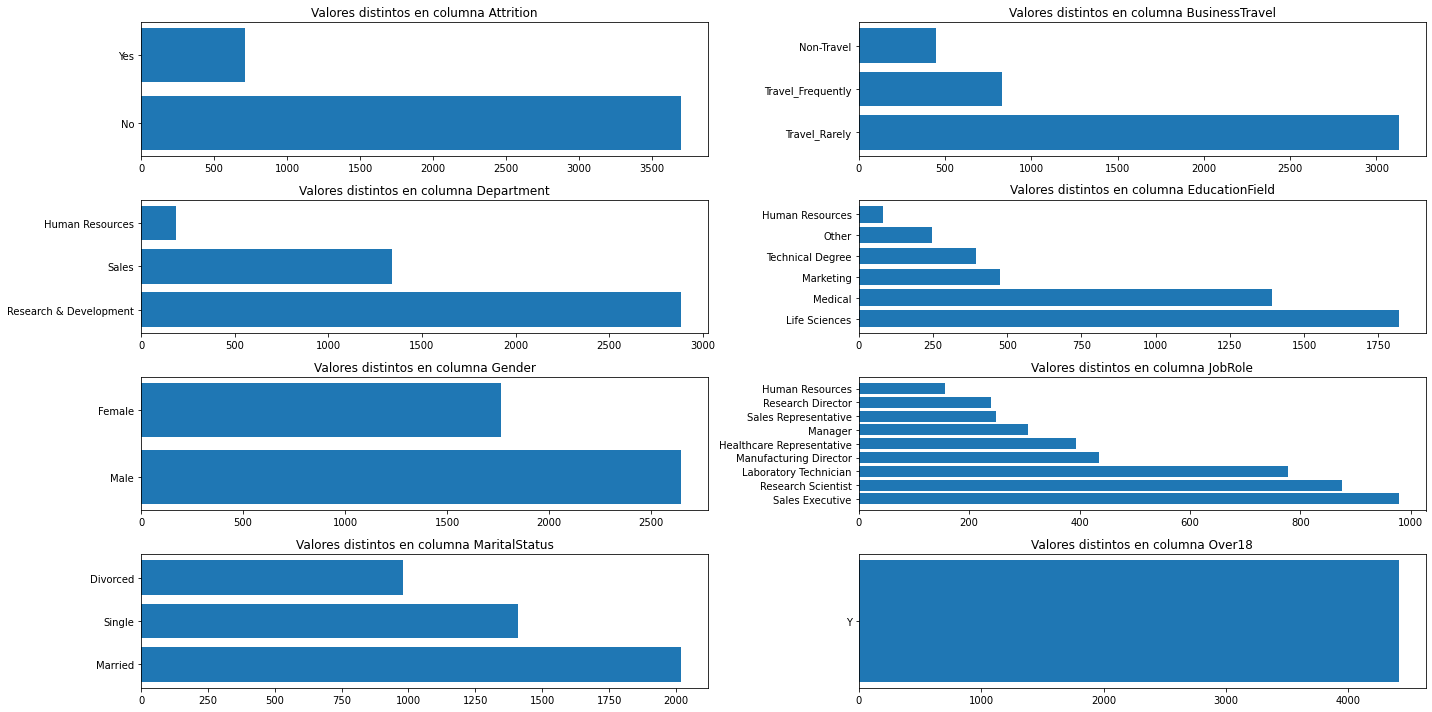

In [9]:
rows = 4
cols = 2
tipo_object = [column for column in df.select_dtypes('object').columns]
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (20,10))
feature = 0
for row in range(rows):
  for col in range(cols):    
    ax[row, col].set_title('Valores distintos en columna '+tipo_object[feature])
    ax[row,col].barh(df[tipo_object[feature]].value_counts().index.to_list(), df[tipo_object[feature]].value_counts().values)
    feature +=1
plt.tight_layout()
plt.show()

Veamos la distribución de la variables numéricas

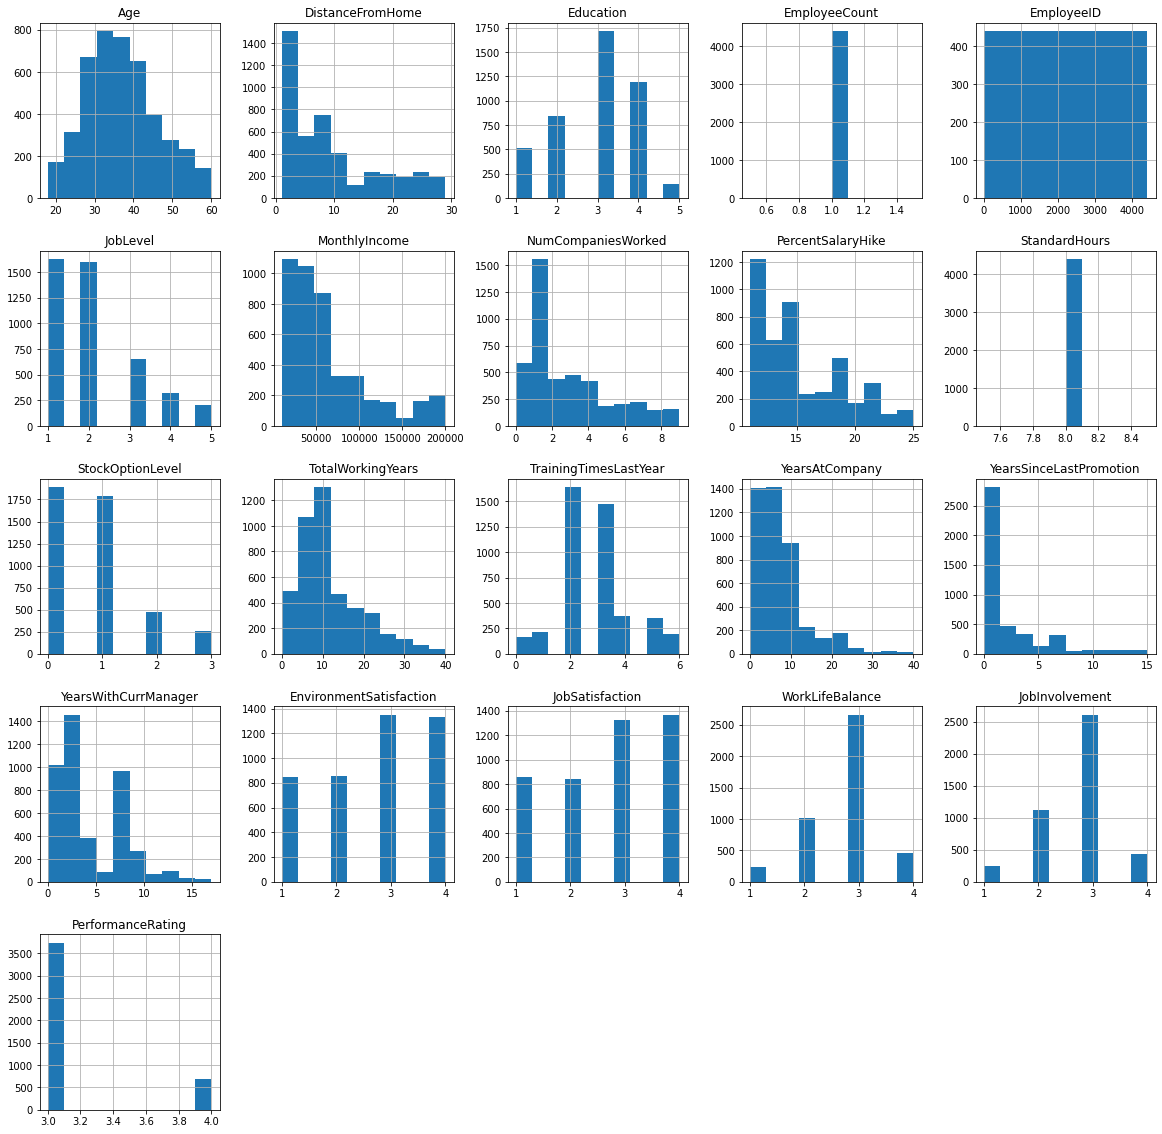

In [10]:
df.hist(figsize=(20, 20))
plt.show()

In [11]:
# eliminaremos la variable Over18, EmployeeCount y StandardHours ya que son constantes y la de EmployeeID tambien ya que no es util para la solucion del problema

df.drop(columns = ['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeID'], inplace = True)

In [12]:
# convertimos de tipo object a categoría

for feature in df.select_dtypes('object'):
  df[feature] = df[feature].astype('category')

## Tratamiento de datos faltantes

In [13]:
imputadas_con_media = []
imputadas_con_frequent = []
for i in features_with_nulls:
  if len(df[i].value_counts().index.to_list()) <= 10:
    print(f'La variable {i} tiene {len(df[i].value_counts().index.to_list())} valores unicos, por ende se tratara como discreta y con metodos de moda o most_frequent')
    imputadas_con_frequent.append(i)
  else:
    print(f'La variable {i} tiene {len(df[i].value_counts().index.to_list())} valores unicos, por ende se tratara como continua y con metodos de media')
    imputadas_con_media.append(i)

La variable NumCompaniesWorked tiene 10 valores unicos, por ende se tratara como discreta y con metodos de moda o most_frequent
La variable TotalWorkingYears tiene 40 valores unicos, por ende se tratara como continua y con metodos de media
La variable EnvironmentSatisfaction tiene 4 valores unicos, por ende se tratara como discreta y con metodos de moda o most_frequent
La variable JobSatisfaction tiene 4 valores unicos, por ende se tratara como discreta y con metodos de moda o most_frequent
La variable WorkLifeBalance tiene 4 valores unicos, por ende se tratara como discreta y con metodos de moda o most_frequent


In [14]:
from sklearn.impute import SimpleImputer

# la columna TotalWorkingYears al tener 40 valores unicos, parece ser que deberia tratarse con la media, pero esto nos devuelve un valor float, esta columna se aproximara al entero mas cercano

mean_imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
most_frequent_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

df[imputadas_con_media] = mean_imputer.fit_transform(df[imputadas_con_media]).astype('float64')
df[imputadas_con_frequent] = most_frequent_imputer.fit_transform(df[imputadas_con_frequent]).astype('int64')

df.TotalWorkingYears = df.TotalWorkingYears.astype('int64')

print(f'Quedamos con {sum(list(df.isnull().sum()))} valores nulos')

Quedamos con 0 valores nulos


## Particionado del dataset en prueba y entrenamiento

Codifiquemos las variables categóricas

In [15]:
df['target'] = df['Attrition'].replace({'Yes': 1, 'No' : 0})

In [16]:
X =  pd.get_dummies(df.drop(columns = ['target', 'Attrition']), drop_first= True)
X.shape
y = df.target.values

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## Entrenemos y probemos varios modelos

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

In [19]:
# hagamos hyperparameters tuning

lr = GridSearchCV(LogisticRegression(penalty = 'l2', max_iter = 1000),
                  param_grid={'class_weight' : ['balanced', None], 'C' : [0.1, 0.5, 1, 5, 10]},
                  cv = 5,
                  return_train_score=False,
                  scoring = 'recall',       
                  n_jobs = -1)

knn = GridSearchCV(KNeighborsClassifier(),
                   param_grid={'weights' : ['uniform', 'distance'], 'n_neighbors': [round(np.sqrt(X_train.shape[0])), 15, 10], 'p': [1,2]},
                  cv = 5,
                  return_train_score=False,
                  scoring = 'recall',       
                  n_jobs = -1)


tree= GridSearchCV(DecisionTreeClassifier(),
                   param_grid={'criterion' : ['gini', 'entropy'], 'max_depth': [3,4,5, None], 'max_leaf_nodes': [2,4,6, None]},
                  cv = 5,
                  return_train_score=False,
                  scoring = 'recall',       
                  n_jobs = -1)

ramdomF = GridSearchCV(RandomForestClassifier(),
                   param_grid={'criterion' : ['gini', 'entropy'], 'max_depth': [3,4,5, None], 'max_leaf_nodes': [2,4,6, None]},
                  cv = 5,
                  return_train_score=False,
                  scoring = 'recall',       
                  n_jobs = -1)

models = [lr, knn, tree, ramdomF]

In [20]:
for model in models:
  print(f'Training {str(model.estimator).split("(")[0]}...')
  model.fit(X_train, y_train)
print('Done!') 

Training LogisticRegression...
Training KNeighborsClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Done!


In [21]:
for model in models:
  print(f'Los mejores 3 combinaciones de parametros de  {str(model.estimator).split("(")[0]} :\n')
  display(pd.DataFrame(model.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score').head(3))
  print('\n')

Los mejores 3 combinaciones de parametros de  LogisticRegression :



,params,mean_test_score,rank_test_score
8,"{'C': 10, 'class_weight': 'balanced'}",0.515943,1
4,"{'C': 1, 'class_weight': 'balanced'}",0.503330,2
0,"{'C': 0.1, 'class_weight': 'balanced'}",0.499727,3




Los mejores 3 combinaciones de parametros de  KNeighborsClassifier :



,params,mean_test_score,rank_test_score
9,"{'n_neighbors': 10, 'p': 1, 'weights': 'distan...",0.847410,1
11,"{'n_neighbors': 10, 'p': 2, 'weights': 'distan...",0.847378,2
7,"{'n_neighbors': 15, 'p': 2, 'weights': 'distan...",0.843806,3




Los mejores 3 combinaciones de parametros de  DecisionTreeClassifier :



,params,mean_test_score,rank_test_score
15,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.892246,1
31,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.865364,2
11,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.233205,3




Los mejores 3 combinaciones de parametros de  RandomForestClassifier :



,params,mean_test_score,rank_test_score
31,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.851014,1
15,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.840219,2
11,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.107690,3


In [22]:
# veamos todas las métricas de los modelos

for model in models:
  print('*'*25, str(model.estimator).split('(')[0],'Metrics', '*'*25, '\n')
  print(classification_report(y_test, model.best_estimator_.predict(X_test)))

************************* LogisticRegression Metrics ************************* 

              precision    recall  f1-score   support

           0       0.88      0.60      0.71       728
           1       0.24      0.60      0.35       154

    accuracy                           0.60       882
   macro avg       0.56      0.60      0.53       882
weighted avg       0.77      0.60      0.65       882

************************* KNeighborsClassifier Metrics ************************* 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       728
           1       0.94      0.98      0.96       154

    accuracy                           0.99       882
   macro avg       0.97      0.98      0.98       882
weighted avg       0.99      0.99      0.99       882

************************* DecisionTreeClassifier Metrics ************************* 

              precision    recall  f1-score   support

           0       0.99      1.00      0.9

# Realizaremos tratamiento de datos para mejorar el desempeños de los modelos

## Veamos la importancia de las variables para determinar si hay algunas que no aportan al problema

Tomaremos el dataframe df para tomar las categóricas de manera original y aplicar label encoding y así poder aplicar algunos tests

In [23]:
# separemos las variables categóricas y las numéricas para aplicar diferentes tests de importancia de variables

df_test = df.copy().drop(columns = ['Attrition', 'target']) # usaremos la y que ya existe en pasos anteriores

# para el analisis de las categoricas tambien usaremos las numericas que son discretas

categoricas_to_test = list(df_test.select_dtypes('category').columns)
categoricas_to_test.extend(['Education', 'JobLevel', 'StockOptionLevel','EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating'])
test_categoricas = df_test[categoricas_to_test]

# para las numericas excluiremos dichas variables que incluimos en categoricas
numericas_to_test = list(df_test.select_dtypes(['int64', 'float64']).drop(columns = ['Education', 'JobLevel', 'StockOptionLevel',\
                                                                                     'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement',\
                                                                                     'PerformanceRating']).columns)
numericas_to_test
test_numericas = df_test[numericas_to_test]

### Test chi2 para variables categóricas en problema de clasificación

Un p-value mayor a 0.05 permite rechazar la hipótesis nula de que 2 variables son indepedientes, es decir que la una depende de la otra. Cuando pensamos en nuestras variables categóricas, nos interesa que ellas sean independientes entre sí, pero que la variable de salida sí sea dependiente de cada una de ellas

In [24]:
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import OrdinalEncoder

# test chi2 para categoricas

encoder = OrdinalEncoder(dtype='int64') # para convertir en numericas las categoricas que faltan
encoded = pd.DataFrame(encoder.fit_transform(test_categoricas.select_dtypes('category')), columns = test_categoricas.select_dtypes('category').columns.to_list())

encoded_df = test_categoricas.select_dtypes('int64').join(encoded)

pd.set_option('display.float_format', lambda x: '%.5f' % x) # para mirar todos los decimales
chi2_test = pd.DataFrame(chi2(encoded_df, y), columns = encoded_df.columns.to_list()).transpose().rename(columns ={0: 'f-score', 1: 'p-value'}).sort_values(by = 'p-value', ascending = False)
chi2_test

,f-score,p-value
BusinessTravel,0.00001,0.99795
PerformanceRating,0.09964,0.75226
StockOptionLevel,0.18850,0.66417
JobInvolvement,0.19861,0.65585
JobLevel,0.27701,0.59867
Education,0.36237,0.54719
Gender,0.57951,0.44651
Department,2.26313,0.13249
WorkLifeBalance,3.13180,0.07678
JobRole,3.99029,0.04576


### Medida ANOVA F para variables numéricas en problema de clasificación

In [25]:
from sklearn.feature_selection import f_classif

f_test = pd.DataFrame(f_classif(test_numericas, y), columns = test_numericas.columns.to_list()).transpose().rename(columns ={0: 'f-score', 1: 'p-value'}).sort_values(by = 'p-value', ascending = False)
f_test

,f-score,p-value
DistanceFromHome,0.41737,0.51829
MonthlyIncome,4.28857,0.03843
PercentSalaryHike,4.67024,0.03074
YearsSinceLastPromotion,4.81102,0.02833
NumCompaniesWorked,7.71438,0.00550
TrainingTimesLastYear,10.79681,0.00102
YearsAtCompany,81.07845,0.00000
YearsWithCurrManager,110.23697,0.00000
Age,114.63168,0.00000
TotalWorkingYears,131.37846,0.00000


In [26]:
# quitamos las variables que no son necesarias en el modelo

drop_chi2 = chi2_test[chi2_test['p-value']>0.05].index.to_list()
drop_fclass = f_test[f_test['p-value']>0.05].index.to_list()

In [27]:
to_drop = drop_fclass + drop_chi2

aux_df = df.drop(columns = to_drop)
aux_df.head()

,Age,Attrition,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,target
0,51,No,Life Sciences,Healthcare Representative,Married,131160,1,11,1,6,1,0,0,3,4,0
1,31,Yes,Life Sciences,Research Scientist,Single,41890,0,23,6,3,5,1,4,3,2,1
2,32,No,Other,Sales Executive,Married,193280,1,15,5,2,5,0,3,2,2,0
3,38,No,Life Sciences,Human Resources,Married,83210,3,11,13,5,8,7,5,4,4,0
4,32,No,Medical,Sales Executive,Single,23420,4,12,9,2,6,0,4,4,1,0


In [28]:
# creamos nuestras X y y de nuevo

X = pd.get_dummies(aux_df.drop(columns = ['Attrition', 'target']), drop_first=True)
y = aux_df.target.values

In [46]:
aux_df.columns

Index(['Age', 'Attrition', 'EducationField', 'JobRole', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'target'],
      dtype='object')

## Veamos correlaciones en las X

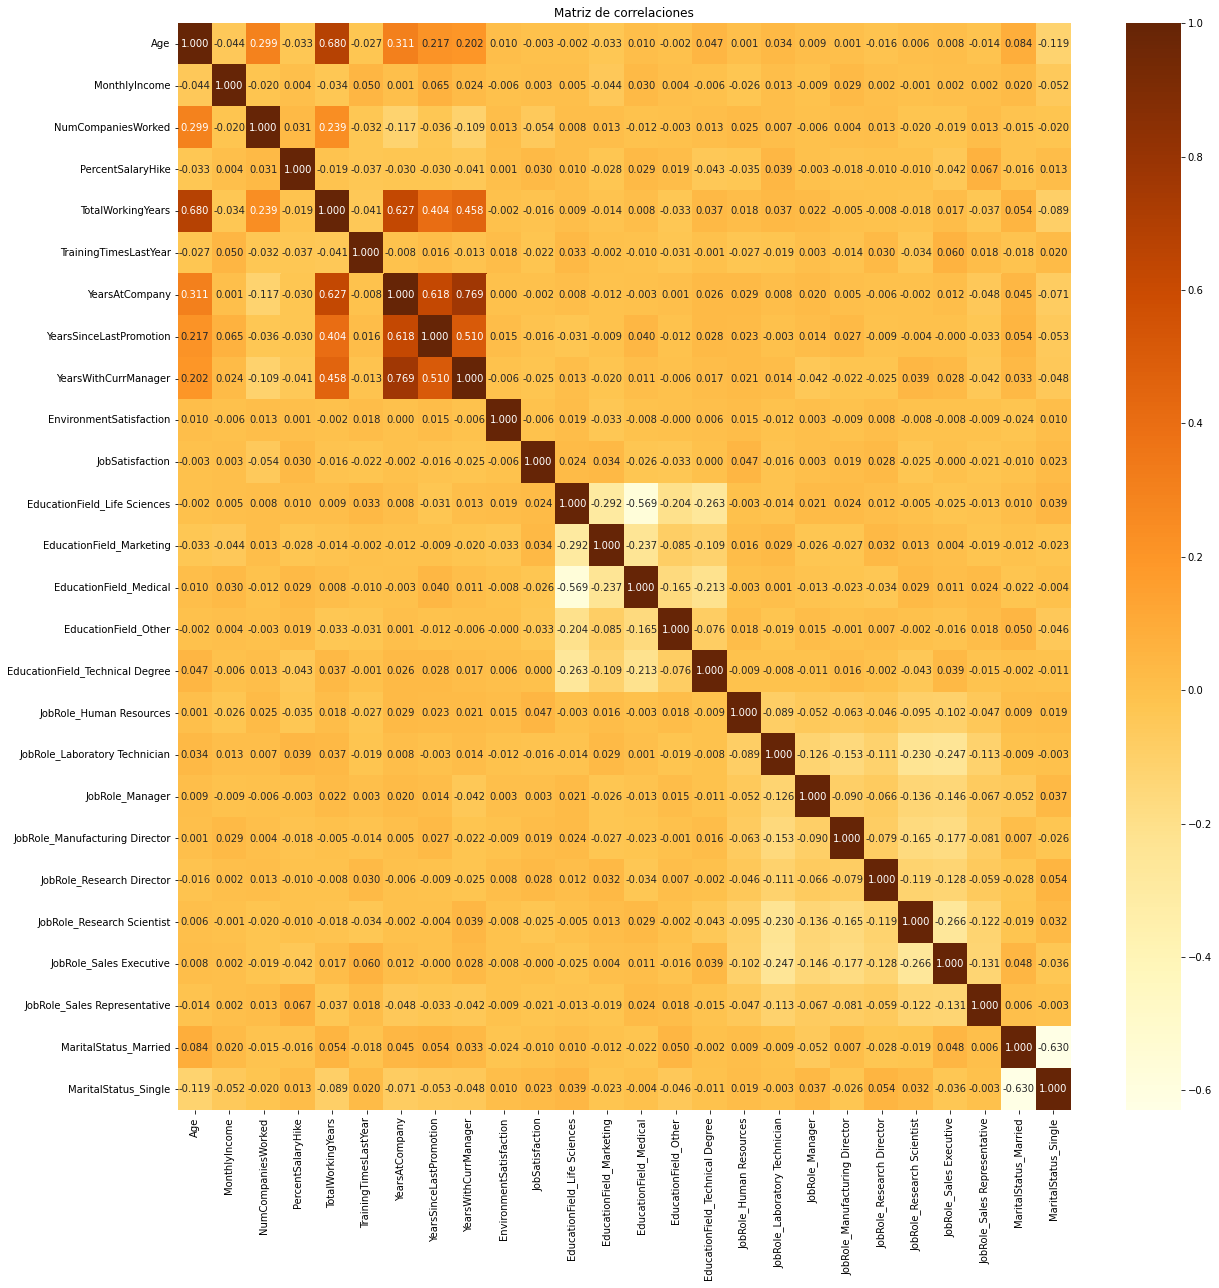

In [29]:
plt.figure(figsize = (20,20))
plt.title('Matriz de correlaciones')
sns.heatmap(X.corr(), annot = True, cmap = 'YlOrBr', fmt='.3f')
plt.show()

## Removeremos datos atípicos

Veámoslos de manera gráfica

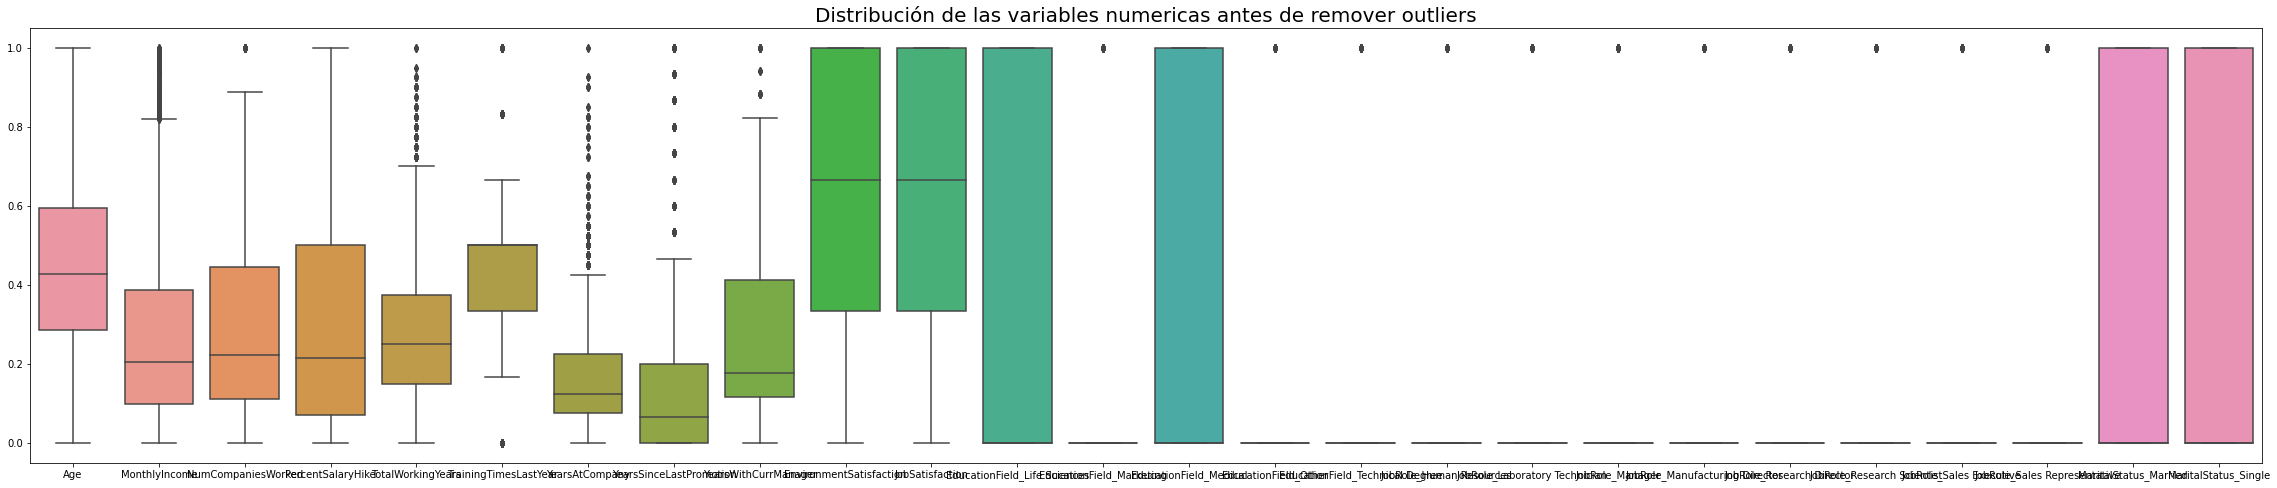

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


plt.figure(figsize = (40, 8))                           
plt.title('Distribución de las variables numericas antes de remover outliers', fontsize = 20)
sns.boxplot(data = pd.DataFrame(scaler.fit_transform(X), columns = X.columns))
plt.show()

In [31]:
def remove_outliers(df, column):
  Q1 = np.quantile(df[column], 0.25)
  Q3 = np.quantile(df[column], 0.75)
  IQR = Q3 - Q1
  cond1 = Q1 - (1.5 * IQR)
  cond2 = Q3 + (1.5 * IQR)
  median = df[column].median()
  df[column] = np.where(( df[column] < cond1 )| (df[column] > cond2), median, df[column])

In [32]:
# los outliers los quitaremos solo para variables que no sean binarias

columns_to_deal_outliers = [column for column in X.columns if X[column].unique().shape[0] > 2]

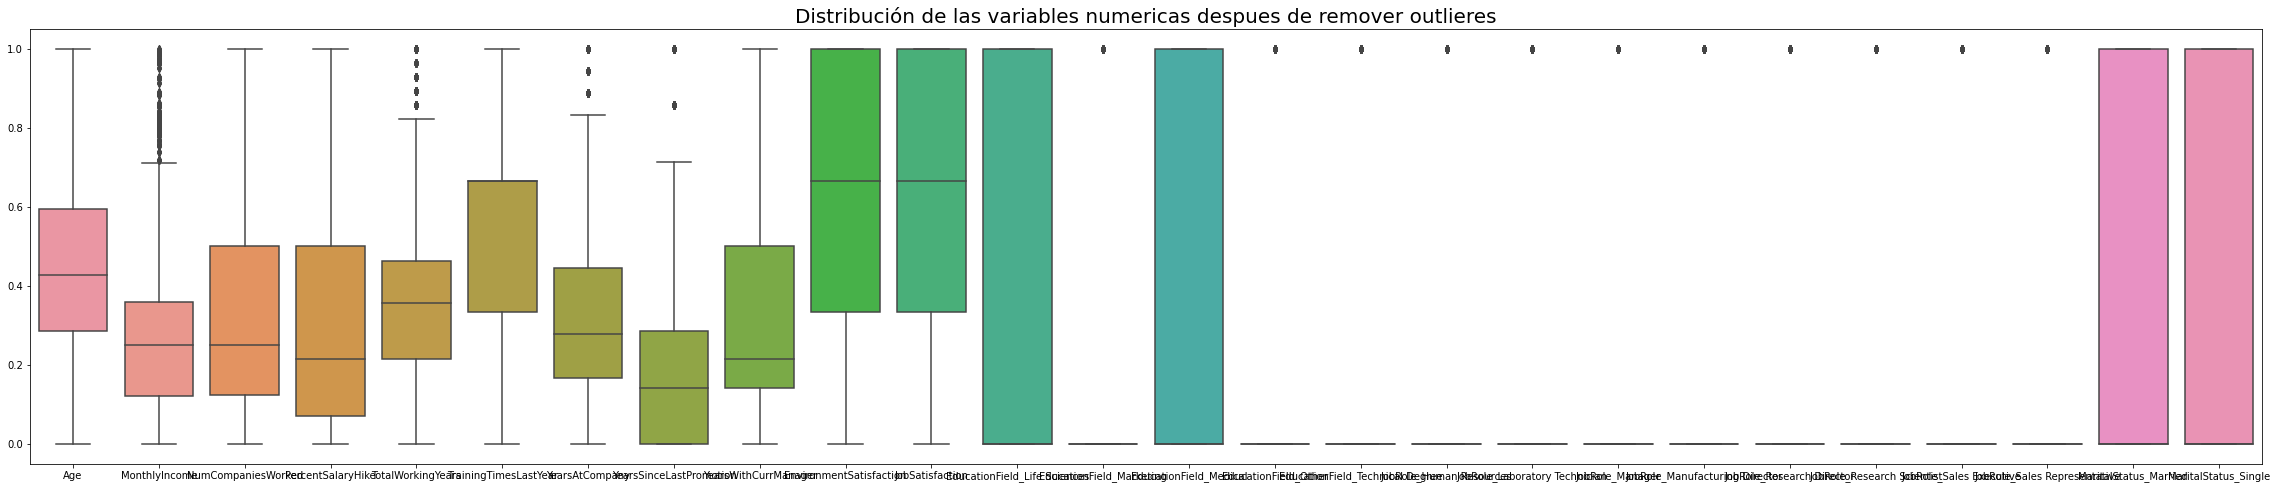

In [33]:
for column in columns_to_deal_outliers:
  remove_outliers(X, column)

# estandarizamos las variables de una vez 

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
plt.figure(figsize = (40, 8))                           
plt.title('Distribución de las variables numericas despues de remover outlieres', fontsize = 20)
sns.boxplot(data = X)
plt.show()

## Hagamos un oversampling de las clases

In [34]:
import imblearn
print(imblearn.__version__)

0.8.1


In [35]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state = 2)
X_res, y_res = oversampler.fit_resample(X, y.ravel())
  
print('Después de samplear, X queda de: {}'.format(X_res.shape))

Después de samplear, X queda de: (7398, 26)


## Particionamos, entrenamos y testeamos

In [36]:
# particionamos nuevamente en entrenamiento y prueba

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=1234)

In [37]:
# entrenemos con los datos resampleados y los GridSearch anteriormente instanciados

for model in models:
  print('Training', str(model.estimator).split('(')[0],'...')
  model.fit(X_train_res, y_train_res)
print('Done!')

Training LogisticRegression ...
Training KNeighborsClassifier ...
Training DecisionTreeClassifier ...
Training RandomForestClassifier ...
Done!


In [38]:
# generamos las métricas de clasificación para los mejores estimadores de cada modelo
for model in models:
  print('*'*25, str(model.estimator).split('(')[0],'Metrics', '*'*25, '\n')
  print(classification_report(y_train_res, model.best_estimator_.predict(X_train_res)))

************************* LogisticRegression Metrics ************************* 

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      2972
           1       0.69      0.72      0.71      2946

    accuracy                           0.70      5918
   macro avg       0.70      0.70      0.70      5918
weighted avg       0.70      0.70      0.70      5918

************************* KNeighborsClassifier Metrics ************************* 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2972
           1       1.00      1.00      1.00      2946

    accuracy                           1.00      5918
   macro avg       1.00      1.00      1.00      5918
weighted avg       1.00      1.00      1.00      5918

************************* DecisionTreeClassifier Metrics ************************* 

              precision    recall  f1-score   support

           0       1.00      1.00      1.0

In [39]:
a = ramdomF.best_estimator_
a

RandomForestClassifier(criterion='entropy')

In [40]:
X_test2 = X_test[X_test_res.columns.to_list()]
X_test2.head()

,Age,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
350,55,43190,4,11,12,3,9,7,3,3,...,0,0,0,1,0,0,0,0,0,1
613,24,28860,1,19,1,5,1,0,0,4,...,0,0,0,1,0,0,0,0,1,0
2707,53,31620,4,15,26,4,14,4,8,3,...,1,0,0,0,0,0,0,0,0,0
1847,35,31400,1,13,17,2,17,5,15,4,...,0,0,0,0,0,0,0,0,1,0
3582,36,47170,1,19,12,3,11,0,7,3,...,0,1,0,0,0,0,0,0,1,0


In [42]:
def preprocessing(df):
  df[to_drop]
  pd.get_dummies(df)
  return df

In [43]:
X_test2.columns.to_list()

['Age',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Married',
 'MaritalStatus_Single']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [75]:
Pipeline([('scaler', scaler), ('prediccion',a)]).predict(X_test2)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [60]:
from sklearn.pipeline import Pipeline

felipe = Pipeline([('scaler', scaler), ('prediccion',a)])


In [ ]:
train_df 
test_df

In [ ]:
felipe.prdcirt()

In [61]:


print(classification_report(y_test, felipe.predict(X_test2)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       728
           1       1.00      0.97      0.98       154

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882



In [62]:
import joblib

In [63]:
joblib.dump(felipe, 'felipe.joblib')

['felipe.joblib']

In [65]:
c =joblib.load('felipe.joblib')

In [73]:
c.steps[1][1].feature_importances_

array([0.09525182, 0.09065568, 0.06892256, 0.07171592, 0.08203026,
       0.04302415, 0.07846949, 0.05391296, 0.08146799, 0.07003733,
       0.07190875, 0.01652337, 0.00868585, 0.01602049, 0.00675877,
       0.00816496, 0.00619306, 0.01143397, 0.00785083, 0.01006978,
       0.00967906, 0.01313261, 0.01868983, 0.00830196, 0.01734582,
       0.03375271])

In [74]:
X_test_res

,Age,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
7313,0.37328,0.22023,0.75000,0.33411,0.19067,0.33333,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000
5035,0.28571,0.25351,0.12500,0.07143,0.03571,0.66667,0.05556,0.00000,0.00000,0.33333,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000
5702,0.19763,0.22318,0.12500,0.50358,0.03571,0.49165,0.05556,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
5505,0.39993,0.07756,0.13135,0.13923,0.18583,0.01693,0.21940,0.00725,0.14286,0.64974,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05078,0.00000,0.00000
403,0.59524,0.24875,0.50000,0.35714,0.14286,1.00000,0.05556,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6714,0.68178,0.03065,0.71715,0.35333,0.38721,0.52635,0.48540,0.83455,0.58272,0.52635,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000
1521,0.30952,0.57237,0.12500,0.14286,0.21429,0.66667,0.27778,0.00000,0.21429,0.66667,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
6056,0.43654,0.24673,0.55043,0.05763,0.29951,0.46781,0.14425,0.08522,0.14286,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
6324,0.24872,0.25151,0.62929,0.28817,0.21306,0.33333,0.21650,0.00000,0.20693,0.64379,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
